## Baseline models

In [1]:
import dataloader
import DataDLC
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import importlib
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

import joblib
from sklearn.metrics import confusion_matrix
import seaborn as sns
import cv2

In [2]:
importlib.reload(dataloader)
importlib.reload(DataDLC)

<module 'DataDLC' from 'c:\\Users\\jalvarez\\Documents\\Code\\GitHubCOde\\Behavioral_Tagging_of_Mice_in_multiple_Mice_dataset_using_Deep_Learning\\src\\DataDLC.py'>

**Load DMD_null male dataset**

# Testing on external Data

DMD femalle

In [24]:
# Deactivate warnings
import warnings
warnings.filterwarnings('ignore')

data_loader = dataloader.DLCDataLoader(r'c:\Users\jalvarez\Documents\Data\DMD_null_female', batch_size=1, num_workers=1, device = 'cpu', build_graph=False)

['DMD_fem_Test_10DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5', 'DMD_fem_Test_11DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5', 'DMD_fem_Test_12DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5', 'DMD_fem_Test_13DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5', 'DMD_fem_Test_14DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5', 'DMD_fem_Test_15DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5', 'DMD_fem_Test_16DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5', 'DMD_fem_Test_17DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5', 'DMD_fem_Test_18DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5', 'DMD_fem_Test_19DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5', 'DMD_fem_Test_1DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5', 'DMD_fem_Test_20DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5', 'DMD_fem_Test_21

In [25]:
dataset = data_loader.data_list

In [26]:
# behaviour names
beh_names = dataset[0][1].columns
beh_names

Index(['General_Contacts', 'Sniffing_R', 'Sniffing_head_R', 'Sniffing_other_R',
       'Sniffing_anal_R', 'Poursuit_R', 'Dominance_R', 'Rearing_R',
       'Grooming_R', 'Sniffing_V', 'Sniffing_head_V', 'Sniffing_other_V',
       'Sniffing_anal_V', 'Poursuit_V', 'Dominance_V', 'Rearing_V',
       'Grooming_V'],
      dtype='object')

In [27]:

y = []
coords_dmd_null = []
behaviour = []

for i in tqdm.tqdm(range(len(dataset))):

    ### Prepare a dataset wich is simply all the points concatenated
    n_frames, n_features_coords = dataset[i][0].values.shape
    n_bp_tot = n_features_coords // 3 # 3 coordinates per body part (body parts of both individuals)
    coords = dataset[i][0].values.reshape(n_frames*n_bp_tot, 3) # Only to treat NANs

    has_nan = np.isnan(coords).any(axis=1)
    coords[has_nan, :] = [0, 0, 0]
    coords = coords.reshape(n_frames, n_features_coords) # Back to the original shape

    if coords.shape[0] != dataset[i][1].shape[0]:
        print("Warrning: ", i, " ", coords.shape[0], " ", dataset[i][1].shape[0])
    coords_dmd_null.append(coords)
    behaviour.append(dataset[i][1].to_numpy())

100%|██████████| 32/32 [00:00<00:00, 174.02it/s]


In [28]:
y = np.concatenate(behaviour)
X = np.concatenate(coords_dmd_null)

In [29]:
print(X.shape)
print(y.shape)

(84165, 108)
(84165, 17)


In [30]:
# Introduce boundaries in features
x_lim = [0, 640]
y_lim = [0, 480]

# Cast outliers to the limits
print( ' before clipping: ', X[:, 0::3].max(), X[:, 0::3].min())
print( ' before clipping: ', X[:, 1::3].max(), X[:, 1::3].min())
X[:, 0::3] = np.clip(X[:, 0::3], x_lim[0], x_lim[1])
X[:, 1::3] = np.clip(X[:, 1::3], y_lim[0], y_lim[1])
print( ' after clipping: ', X[:, 0::3].max(), X[:, 0::3].min())
print( ' after clipping: ', X[:, 1::3].max(), X[:, 1::3].min())

 before clipping:  744.7799998844399 -1742.2799189725774
 before clipping:  1166.3409529420117 -178.30495189603099
 after clipping:  640.0 0.0
 after clipping:  480.0 0.0


In [31]:
# Scale the data 
X[:, 0::3] = (X[:, 0::3] - x_lim[0]) / (x_lim[1] - x_lim[0])
X[:, 1::3] = (X[:, 1::3] - y_lim[0]) / (y_lim[1] - y_lim[0])

In [32]:
print( ' after clipping: ', X[:, 0::3].max(), X[:, 0::3].min())
print( ' after clipping: ', X[:, 1::3].max(), X[:, 1::3].min())

 after clipping:  1.0 0.0
 after clipping:  1.0 0.0


In [33]:
print(X.shape)

(84165, 108)


___

In [34]:
beh_names[0]

'General_Contacts'

## General contact

In [42]:
# Load the model
model = joblib.load('baseline_models/model_gencont.pkl')
print(model)

MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000, verbose=True)


In [43]:
# Test the model
y_pred = model.predict(X)

accuracy_score(y[:, 0], y_pred)

0.7890334462068556

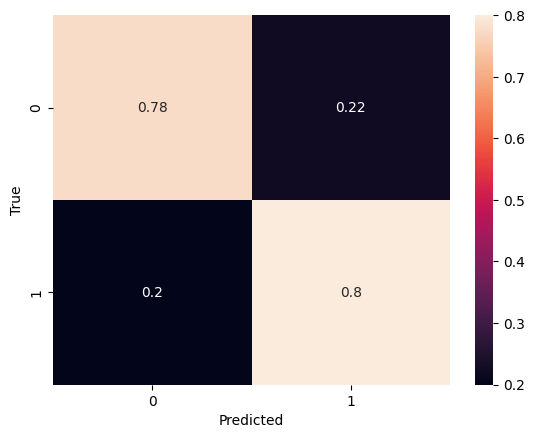

In [44]:
# Confusion matrix
conf_matrix = confusion_matrix(y[:, 0], y_pred)
conf_matrix = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_matrix, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


___

In [45]:
beh_names[1]

'Sniffing_R'

In [46]:
# Load the model
model = joblib.load('baseline_models/model_sniffR.pkl')
print(model)


MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000, verbose=True)


In [47]:
# tEST THE MODEL
y_pred = model.predict(X)

accuracy_score(y[:, 1], y_pred)

0.7919087506683301

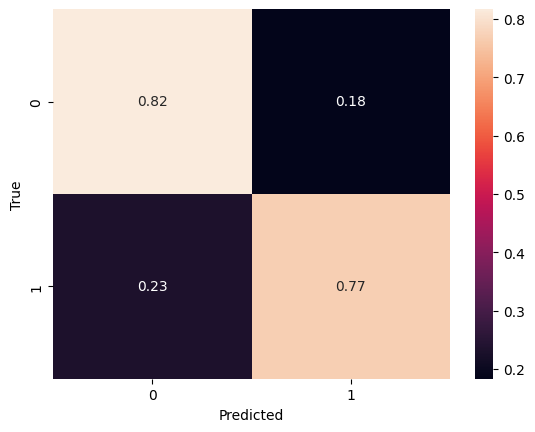

In [48]:
# Confusion matrix
conf_matrix = confusion_matrix(y[:, 1], y_pred)
conf_matrix = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_matrix, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


---

In [49]:
beh_names[5]

'Poursuit_R'

In [50]:
# Load the model
model = joblib.load('baseline_models/new_dataset/model_poursuitR.pkl')
print(model)

MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000, verbose=True)


In [51]:
# Test the model
y_pred = model.predict(X)

accuracy_score(y[:, 5], y_pred)

0.8333155111982415

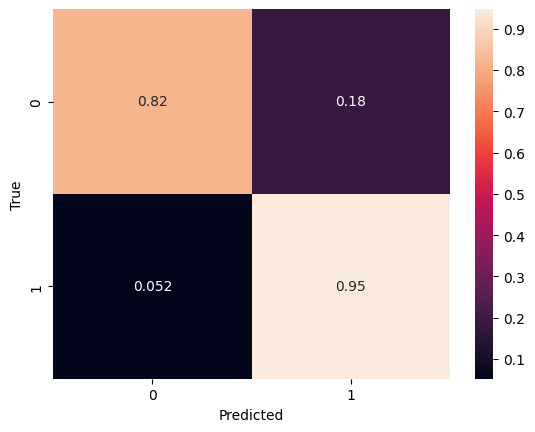

In [52]:
# Confusion matrix
conf_matrix = confusion_matrix(y[:, 5], y_pred)

conf_matrix = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

sns.heatmap(conf_matrix, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


---

In [53]:
beh_names[6]

'Dominance_R'

In [54]:
# Load the model
model = joblib.load('baseline_models/model_domR.pkl')
print(model)

MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000, verbose=True)


In [55]:
# Test the model
y_pred = model.predict(X)

accuracy_score(y[:, 6], y_pred)


0.7043070159805145

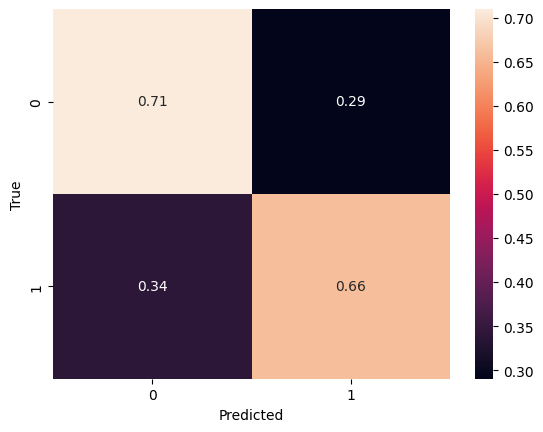

In [56]:
# Confusion matrix
conf_matrix = confusion_matrix(y[:, 6], y_pred)
conf_matrix = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_matrix, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


---

In [57]:
beh_names[7]

'Rearing_R'

In [58]:
# Load the model
model = joblib.load('baseline_models/model_rearingR.pkl')
print(model)

MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000, random_state=42,
              verbose=True)


In [59]:
# Test the model
y_pred = model.predict(X)

accuracy_score(y[:, 7], y_pred)


0.8353353531753104

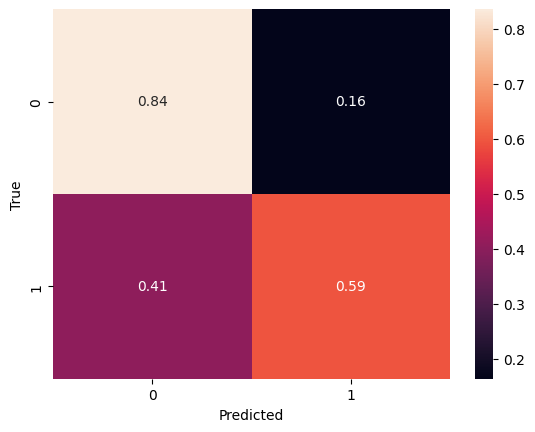

In [60]:
# Confusion matrix
conf_matrix = confusion_matrix(y[:, 7], y_pred)
conf_matrix = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_matrix, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


---

In [43]:
beh_names[8]

'Grooming_R'

In [44]:
# Load the model
model = joblib.load('baseline_models/model_groomR.pkl')
print(model)

MLPClassifier(hidden_layer_sizes=100, max_iter=1000, verbose=True)


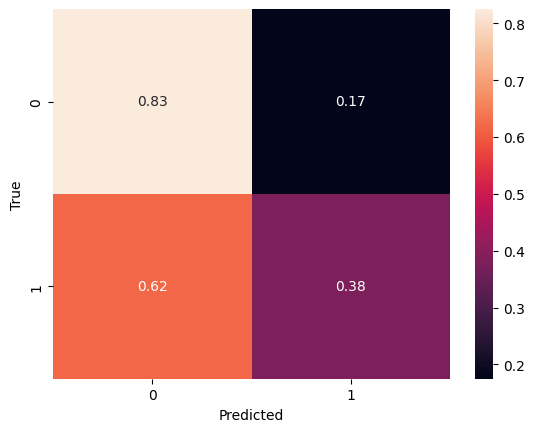

In [45]:
# Test the model
y_pred = model.predict(X)

accuracy_score(y[:, 8], y_pred)

# Confusion matrix
conf_matrix = confusion_matrix(y[:, 8], y_pred)
conf_matrix = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_matrix, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
